In [1]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf



In [2]:
# anulo el uso de la GPU por falta de memoria
import os, sys
os.environ['CUDA_VISIBLE_DEVICES'] = '0' #'-1' for no GPU

if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

# No GPU found

# tf.enable_eager_execution()
tf.VERSION

GPU found


'1.13.1'

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
from skimage.transform import resize
from imgaug import augmenters as iaa
from tqdm import tqdm
import PIL
from PIL import Image, ImageOps
import cv2

from sklearn.utils import class_weight, shuffle
from keras.losses import binary_crossentropy
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import InputLayer
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
import keras.backend as K

from sklearn.metrics import f1_score, fbeta_score
from keras.utils import Sequence
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

WORKERS = 2
CHANNEL = 3

import warnings
warnings.filterwarnings("ignore")
IMG_SIZE = 512
NUM_CLASSES = 5
SEED = 77
TRAIN_NUM = 1000 # use 1000 when you just want to explore new idea, use -1 for full train


DATA_PATH = "data"

Using TensorFlow backend.


In [4]:
import os
print(os.listdir("data"))

['results_df_20190710232755.pkl', 'results_test_df_20190710232755.pkl', 'processed_train_images', 'results_df_20190711090031.pkl', 'results_test_models_df_20190711111832.pkl', 'results_test_df_20190712001832.pkl', 'train.csv', 'results_df.pkl', 'train_images', 'test.csv', 'test_images', 'results_test_df_20190711090031.pkl', 'processed_test_images', 'results_test_df.pkl', 'sample_submission.csv', 'results_df_20190712001832.pkl', 'results_test_model2_df_20190711111855.pkl', 'results_test_model2_df_20190712083607.pkl']


In [5]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14890473302596797524
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 6588522607690001958
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 14060119475075959634
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7286256436
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7808360314913263457
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


# 1. Introduction. Explore first, train later.

Hi everyone! As *Aravind Eye Hospital* is one of my favorite organization in the world; they take care of poor people's eyes for free with an impressive sustainable business model.  I will try my best to contribute something to our community. One intuitive way to improve the performance of our model is to simply improve the quality of input images. In this kernel, I will share two ideas which I hope may be useful to some of you : 

- **Decolorize images** : here as we will see, images come with many different lighting conditions, some images are quite dark and difficult to visualize. We can try to convert the image to gray scale, and visualize better. Alternatively, we can try the method of [Ben Graham (last competition's winner)](https://github.com/btgraham/SparseConvNet/tree/kaggle_Diabetic_Retinopathy_competition)
- **Cropping uninformative area** : everyone know this :) Here, I just find the codes from internet and choose the best one for you :)

We are going to apply both techniques to both the official data, and the past competition data (shout out @tanlikesmath for creating this dataset! https://www.kaggle.com/tanlikesmath/diabetic-retinopathy-resized . In the updated version, I also try @donkeys' dataset https://www.kaggle.com/donkeys/retinopathy-train-2015 , which is .png which may be have higer image quality than .jpeg format)

If I found more useful tricks, I will update the notebook, or if you have more useful tricks and would love to share, please let me know!

I use some parts of codes from @mathormad and @artgor kernels. Thanks both of you!

Now let us start by loading the train/test dataframes. The `train_test_split` here is in fact not necessary. But when I first fork the kernel from @mathormad, I found some interesting examples using this split and the current `SEED`, so I continue to use them here.

In [6]:
df_train = pd.read_csv(DATA_PATH + '/train.csv')
df_test = pd.read_csv(DATA_PATH + '/test.csv')

x = df_train['id_code']
y = df_train['diagnosis']

x, y = shuffle(x, y, random_state=SEED)


(3662,) (3662,)
000c1434d8d7 2


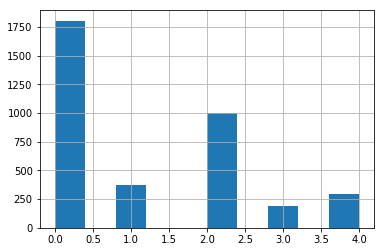

In [7]:
print(x.shape,  y.shape)
print(x[0],y[0])
y.hist()

In [8]:
print(df_train.groupby('diagnosis').count())

           id_code
diagnosis         
0             1805
1              370
2              999
3              193
4              295


In [9]:
num_images_list = [450, 370, 400, 193, 295]

counters = [0,0,0,0,0]



for i, row in df_train.iterrows():
    if counters[row[1]] >= num_images_list[row[1]]:
        df_train = df_train.drop(i, axis=0)
    else:
        counters[row[1]] += 1

print(df_train.shape)
        
x1 = df_train['id_code']
y1 = df_train['diagnosis']

x1, y1 = shuffle(x1, y1, random_state=SEED)

(1708, 2)


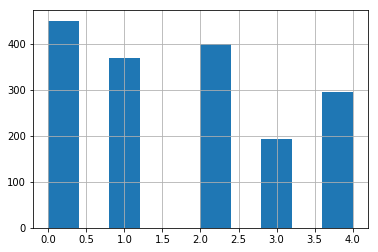

In [10]:
y1.hist()

In [11]:
num_images = len(x1)
print(num_images)

1708


## 1.1 Simple picture to explain Diabetic Retinopathy

How do we know that a patient have diabetic retinopahy? There are 5 things to spot on. Image credit https://www.eyeops.com/
![credit : https://www.eyeops.com/](https://sa1s3optim.patientpop.com/assets/images/provider/photos/1947516.jpeg)

From quick investigations of the data (see various pictures below), I found that *Hemorrphages, Hard Exudates and Cotton Wool spots* are quite easily observed. However, I still could not find examples of *Aneurysm* or *Abnormal Growth of Blood Vessels* from our data yet. Perhaps the latter two cases are important if we want to catch up human benchmnark using our model.

## Process Images

In [12]:
def crop_image1(img,tol=8):
    # img is image data
    # tol  is tolerance
        
    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]


In [13]:
def enhance(image, clip_limit=3, Crop = True, size=(400,500)):
    # convert image to LAB color model
    
    image_lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

    # split the image into L, A, and B channels
    l_channel, a_channel, b_channel = cv2.split(image_lab)

    # apply CLAHE to lightness channel
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=(8, 8))
    cl = clahe.apply(l_channel)

    # merge the CLAHE enhanced L channel with the original A and B channel
    merged_channels = cv2.merge((cl, a_channel, b_channel))

    # convert iamge from LAB color model back to RGB color model
    image = cv2.cvtColor(merged_channels, cv2.COLOR_LAB2BGR)
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Auto Crop image
    cropped_image = crop_image1(image_gray, 8)
    
    # resize image
    resized_image = cv2.resize(cropped_image, size)
    # Include Ben Graham preprocessing (-4 value)
    if Crop:
        final_image=cv2.addWeighted ( resized_image,4, 
                                     cv2.GaussianBlur( resized_image , (0,0) , IMG_SIZE/10) ,-4 ,128)
        return final_image
    else:
        return resized_image

In [14]:
import tqdm

# Aquí transcribimos las imágenes a un fichero tipo TFRECORD de tamaño
# el primer modelo usaba imágenes de 100x125
width = 400
height = 500

size = (width,height)
image_x = []

for i in tqdm.tqdm(x1):
    path=f"/mnt/DATA-SSD/DataSandbox/APTOS/train_images/{i}.png"
    image = cv2.imread(path)
    enhanced_image = enhance(image,2, True, size)
    # img = image.img_to_array(enhanced_image)
    img = enhanced_image.reshape((width, height, 1))/255
    image_x.append(img)

X = np.array(image_x)

Y = to_categorical(y1)



100%|██████████| 1708/1708 [05:55<00:00,  5.18it/s]


In [15]:
print(len(x), X.shape)
print(len(Y), Y.shape)

3662 (1708, 400, 500, 1)
1708 (1708, 5)


# The Model
## inspired in real life

help obtained from
https://machinelearningmastery.com/keras-functional-api-deep-learning/


In [22]:
# ---------------------
# OPTION 1
# ---------------------
''' '''

input_layer = tf.keras.Input(shape=(width,height,1))
print('input_layer: ', input_layer.shape)

layer01 = tf.keras.layers.Conv2D(200, kernel_size=(5, 5), activation='relu')(input_layer)
print('layer: ', layer01.shape)

layer02 = tf.keras.layers.MaxPooling2D(pool_size=(5, 5))(layer01)
print('layer: ', layer02.shape)

layer03 = tf.keras.layers.Conv2D(200, kernel_size=(2, 2), activation='relu')(layer02)
print('layer: ', layer03.shape)

layer04 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(layer03)
print('layer: ', layer04.shape)

layer05 = tf.keras.layers.Conv2D(100, kernel_size=(2, 2), activation='relu')(layer04)
print('layer: ', layer05.shape)

layer06 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(layer05)
print('layer: ', layer06.shape)

layer07 = tf.keras.layers.Conv2D(100, kernel_size=(2, 2), activation='relu')(layer06)
print('layer: ', layer07.shape)

layer08 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(layer07)
print('layer: ', layer08.shape)

layer09 = tf.keras.layers.Flatten()(layer08)
print('layer: ', layer09.shape)

layer10 = tf.keras.layers.Dense(10*NUM_CLASSES, activation='relu')(layer09)
print('layer: ', layer10.shape)

output_layer = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(layer10)
print('output_layer: ', output_layer.shape)

model = tf.keras.Model(inputs = [input_layer], outputs = [output_layer])



input_layer:  (?, 400, 500, 1)
layer:  (?, 396, 496, 200)
layer:  (?, 79, 99, 200)
layer:  (?, 78, 98, 200)
layer:  (?, 39, 49, 200)
layer:  (?, 38, 48, 100)
layer:  (?, 19, 24, 100)
layer:  (?, 18, 23, 100)
layer:  (?, 9, 11, 100)
layer:  (?, 9900)
layer:  (?, 50)
output_layer:  (?, 5)


In [23]:
print(model.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 400, 500, 1)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 396, 496, 200)     5200      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 79, 99, 200)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 78, 98, 200)       160200    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 39, 49, 200)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 38, 48, 100)       80100     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 19, 24, 100)       0         
__________

In [24]:
# config = tf.ConfigProto(device_count = {'GPU': 0})
# config.gpu_options.allow_growth = True
# gpu_options = tf.GPUOptions(allow_growth=True)

# session = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))


In [25]:
# run_opts = tf.RunOptions(report_tensor_allocations_upon_oom = True)

In [26]:
model.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

In [ ]:
import datetime
# este es el modelo estándar, con la entrada y la salida esperadas
# hay que sustituirlo por un iterador.


# No olvidarse de incluir un train_history para recuperar los datos del entrenamiento
# 5000 epochs es una locura y el número de steps per epoch es muy bajo (no se recorren todas las imagenes)
# el mínimo steps_per_epoch debería de ser total_muestras/batch_size

lt = datetime.datetime.now().strftime("%Y%m%d%H%M%S")

model_file = "/mnt/DATA-SSD/DataSandbox/APTOS/model_" + lt + "_{epoch:04d}.h5"

# with callback
train_history = model.fit(X, Y,
                          batch_size = 10,
                          epochs=1000,
                          verbose=1,
                          shuffle = True,
                          callbacks = [tf.keras.callbacks.ModelCheckpoint(model_file, 
                                                                          save_weights_only = False,
                                                                          verbose=1,
                                                                          period=10)])


Epoch 1/1000
1708/1708 [==============================] - 29s 17ms/sample - loss: 1.4290 - acc: 0.3876
Epoch 2/1000
1708/1708 [==============================] - 28s 16ms/sample - loss: 1.1976 - acc: 0.5129
Epoch 3/1000
1708/1708 [==============================] - 28s 17ms/sample - loss: 1.1590 - acc: 0.5310
Epoch 4/1000
1708/1708 [==============================] - 28s 17ms/sample - loss: 1.1340 - acc: 0.5340
Epoch 5/1000
1708/1708 [==============================] - 28s 17ms/sample - loss: 1.0974 - acc: 0.5544
Epoch 6/1000
1708/1708 [==============================] - 28s 16ms/sample - loss: 1.0990 - acc: 0.5597
Epoch 7/1000
1708/1708 [==============================] - 28s 17ms/sample - loss: 1.0603 - acc: 0.5855
Epoch 8/1000
1708/1708 [==============================] - 27s 16ms/sample - loss: 1.0330 - acc: 0.5796
Epoch 9/1000
1708/1708 [==============================] - 27s 16ms/sample - loss: 1.0074 - acc: 0.5785
Epoch 10/1000
1700/1708 [============================>.] - ETA: 0s - loss

Epoch 70/1000
1700/1708 [============================>.] - ETA: 0s - loss: 0.1168 - acc: 0.9547
Epoch 00070: saving model to /mnt/DATA-SSD/DataSandbox/APTOS/model_20190713105126_0070.h5
1708/1708 [==============================] - 29s 17ms/sample - loss: 0.1167 - acc: 0.9543
Epoch 71/1000
1708/1708 [==============================] - 29s 17ms/sample - loss: 0.1298 - acc: 0.9467
Epoch 72/1000
1708/1708 [==============================] - 29s 17ms/sample - loss: 0.0862 - acc: 0.9660
Epoch 73/1000
1708/1708 [==============================] - 28s 17ms/sample - loss: 0.0905 - acc: 0.9649
Epoch 74/1000
1708/1708 [==============================] - 28s 17ms/sample - loss: 0.0885 - acc: 0.9666
Epoch 75/1000
1708/1708 [==============================] - 29s 17ms/sample - loss: 0.0872 - acc: 0.9678
Epoch 76/1000
1708/1708 [==============================] - 29s 17ms/sample - loss: 0.0819 - acc: 0.9660
Epoch 77/1000
1708/1708 [==============================] - 30s 17ms/sample - loss: 0.1131 - acc: 0.9

1708/1708 [==============================] - 29s 17ms/sample - loss: 0.0412 - acc: 0.9830
Epoch 137/1000
1708/1708 [==============================] - 29s 17ms/sample - loss: 0.0385 - acc: 0.9819
Epoch 138/1000
1708/1708 [==============================] - 29s 17ms/sample - loss: 0.1384 - acc: 0.9543
Epoch 139/1000
1708/1708 [==============================] - 29s 17ms/sample - loss: 0.1788 - acc: 0.9374
Epoch 140/1000
1700/1708 [============================>.] - ETA: 0s - loss: 0.0507 - acc: 0.9800
Epoch 00140: saving model to /mnt/DATA-SSD/DataSandbox/APTOS/model_20190713105126_0140.h5
1708/1708 [==============================] - 29s 17ms/sample - loss: 0.0504 - acc: 0.9801
Epoch 141/1000
1708/1708 [==============================] - 29s 17ms/sample - loss: 0.0343 - acc: 0.9830
Epoch 142/1000
1708/1708 [==============================] - 29s 17ms/sample - loss: 0.0297 - acc: 0.9854
Epoch 143/1000
1708/1708 [==============================] - 29s 17ms/sample - loss: 0.0398 - acc: 0.9824
Epo

1708/1708 [==============================] - 27s 16ms/sample - loss: 0.0227 - acc: 0.9848
Epoch 203/1000
1708/1708 [==============================] - 27s 16ms/sample - loss: 0.0251 - acc: 0.9854
Epoch 204/1000
1708/1708 [==============================] - 27s 16ms/sample - loss: 0.0248 - acc: 0.9865
Epoch 205/1000
1708/1708 [==============================] - 27s 16ms/sample - loss: 0.0256 - acc: 0.9830
Epoch 206/1000
1708/1708 [==============================] - 27s 16ms/sample - loss: 0.0237 - acc: 0.9842
Epoch 207/1000
1708/1708 [==============================] - 27s 16ms/sample - loss: 0.0245 - acc: 0.9854
Epoch 208/1000
1708/1708 [==============================] - 27s 16ms/sample - loss: 0.0241 - acc: 0.9830
Epoch 209/1000
1708/1708 [==============================] - 27s 16ms/sample - loss: 0.0220 - acc: 0.9854
Epoch 210/1000
1700/1708 [============================>.] - ETA: 0s - loss: 0.0273 - acc: 0.9841
Epoch 00210: saving model to /mnt/DATA-SSD/DataSandbox/APTOS/model_20190713105

In [ ]:
# summarize history for accuracy
plt.plot(train_history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(train_history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Choose 5 random images one for each different diagnosis value

image_list = []
for class_id in sorted(y.unique()):
    image_list.append(df_train.loc[df_train['diagnosis'] == class_id].sample(1, random_state=SEED))

image_list

In [ ]:
predict = {}

for i in image_list:
    path=f"/mnt/DATA-SSD/DataSandbox/APTOS/train_images/{i.iloc[0][0]}.png"
    print(path)
    image = cv2.imread(path)
    enhanced_image = enhance(image,2, True, size)
    # img = image.img_to_array(enhanced_image)
    img = enhanced_image.reshape((1,width, height, 1))/255
    predict[i.iloc[0][0]] = [i.iloc[0][1], model.predict(img)]


predict

In [ ]:
results_train = {}
for i in tqdm.tqdm(df_train.iterrows()):
    path=f"/mnt/DATA-SSD/DataSandbox/APTOS/train_images/{i[1][0]}.png"
    image = cv2.imread(path)
    enhanced_image = enhance(image,2, True, size)
    # img = image.img_to_array(enhanced_image)
    img = enhanced_image.reshape((1,width, height, 1))/255
    results_train[i[0]] = [i[1][0], i[1][1], model.predict(img)]


In [ ]:
results_df = pd.DataFrame.from_dict(results_train, 
                                    orient='index', 
                                    columns=['imge_id', 'diagnoses', 'prediction'])

In [ ]:
def diagnoses_from_list(row):
    n = 0.0
    diagnoses = 0.0
    for i in row[0]:
        diagnoses += i*n
        n += 1.0
    return int(diagnoses)



In [ ]:
# print(results_df.iloc[0][2])
# print(diagnoses_from_list(results_df.prediction[0]))
results_df['predicted_diagnoses'] = results_df.apply( lambda x: diagnoses_from_list(x.prediction), axis=1)
results_df['predict_ok'] = results_df.apply( lambda x: 1 if x.predicted_diagnoses==x.diagnoses else 0, axis=1)
results_df['predict_error'] = results_df.apply( lambda x: 1 if x.predicted_diagnoses!=x.diagnoses else 0, axis=1)
results_df['prediction_error'] = results_df['diagnoses'].sub(results_df['predicted_diagnoses'])
results_df.sum(axis=0)
# results_df

In [ ]:
results_df.groupby('diagnoses').count()


In [ ]:
results_df.groupby('diagnoses').sum()

In [ ]:
lt = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
results_df.to_pickle(f"/mnt/DATA-SSD/DataSandbox/APTOS/results_df_{lt}.pkl")